In [81]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf

#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

### Upload do dataframe:

In [82]:
import yfinance as yf

# Especifique o símbolo da IBOVESPA (^BVSP) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-08'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [83]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800


In [84]:
df.shape #analisando linhas e colunas

(1490, 7)

In [85]:
df_ibovespa = df # criando cópia do dataset

### Visualizando os valores de fechamento

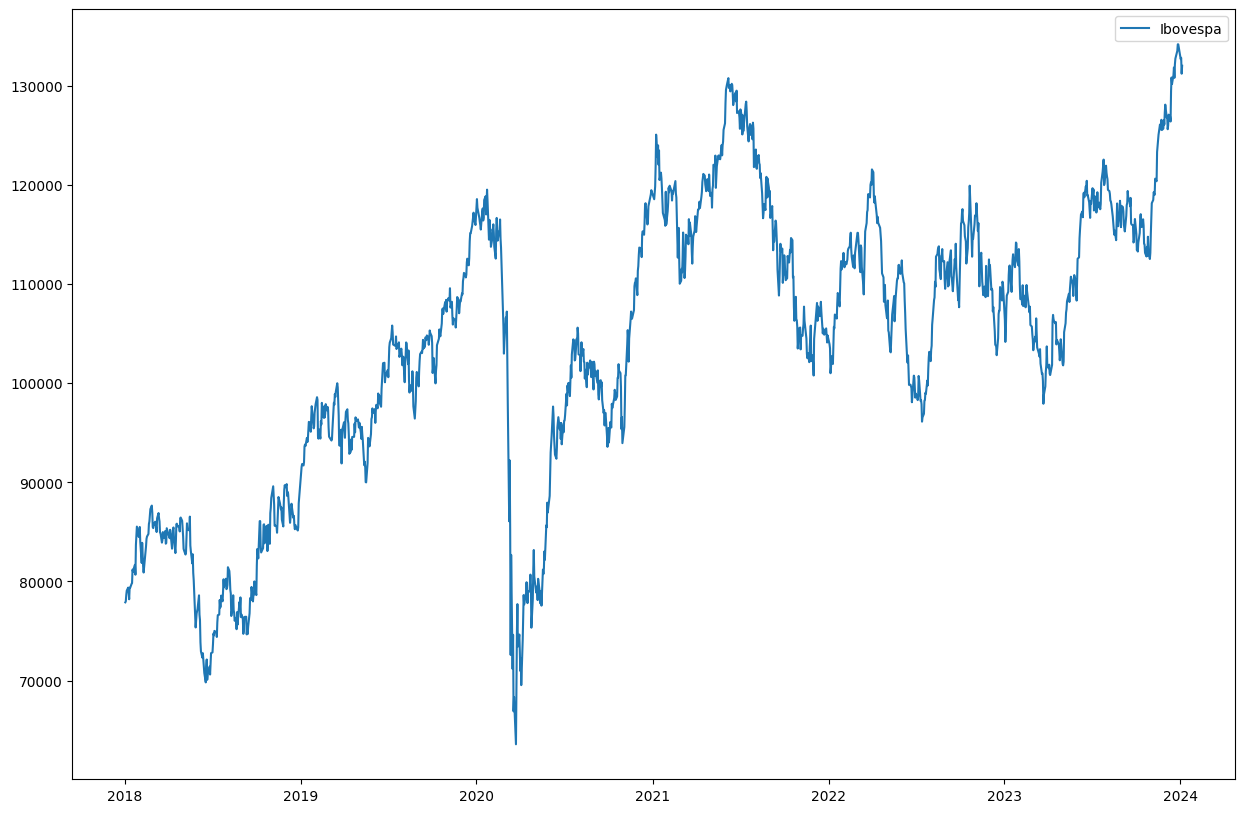

In [86]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Close'], label='Ibovespa')

plt.legend(loc='best')
plt.show()

# Análise de série temporal (Decomposição) 📈

Dentro das etapas de análise de uma série temporal, existe a etapa da realização de sua decomposição. Decompor uma série temporal significa você analisar:

- Tendencia
- Sazonalidade
- Ruído

Iremos utilizar o Statsmodel para decompor nossos dados e visualizar vários gráficos. Utilizar a decomposição dos dados da série pode **auxiliar na compreensão dos dados e na tomada de decisão de qual modelo preditivo utilizar**.

Ao compreender a tendência, podemos fazer previsões de longo prazo.

Ao entender a sazonalidade, podemos prever padrões de curto prazo.

E ao analisar os resíduos, podemos entender o que não foi capturado pelos dois primeiros componentes e, assim, melhorar nossos modelos. 😊

## O que é tendência?
**Direcionamento** de sua série temporal (para qual direção ela está indo).

## O que é Sazonalidade?
Encontrar **caracteristicas e padrões no tempo** que podem aparecer de forma repetida.

## O que é o ruído?
Após extrair a tendência e a sazonalidade da série original, o que resta é chamado de resíduo. Os resíduos são a **diferença entre a série original e o que foi explicado pela tendência e sazonalidade**.

## Série aditiva ou multiplicativa

A decomposição pode ajudar a identificar se uma série temporal é **aditiva ou multiplicativa**. Uma série é considerada **aditiva** quando a **magnitude da sazonalidade e da tendência não varia com o tempo**. Por outro lado, em uma série **multiplicativa**, a **magnitude da sazonalidade ou da tendência varia em proporção ao nível da série.**



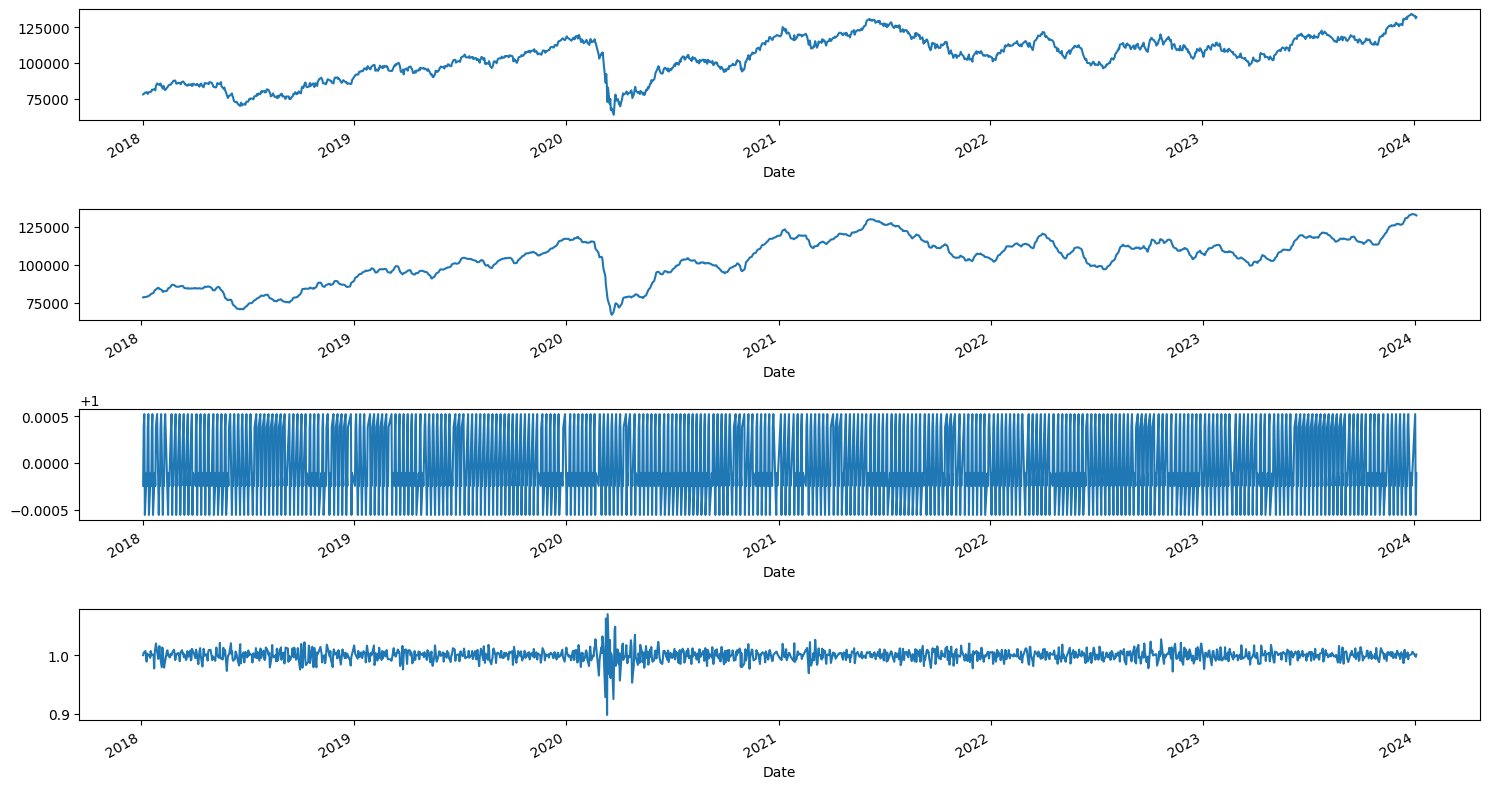

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## E por que as ações estão caindo? 🏰✨

**Uma das possíveis causas:** Pandemia do covid trouxe grandes impcatos que a disney está enfrentando até os dias de hoje (em 2023).

**Recomendação de vídeo:** https://youtu.be/v7ybYLS9tTo?si=mSIneB3BLd-YbEn9


✨**Dica:** Na análise exploratória, não vale apenas olhar para os dados, mas também entender o que aconteceu com o mundo, a economia e todos os fatores externos que podem ter impactado as variações da série temporal.

## Testando modelos clássicos: Média Móvel 📈⏳

Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a **média de N dias observados para prever o próximo dia**. Vamos utilizar esta técnica para um N de 10 e de 20 dias.


In [88]:
#Filtrando os dados
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)

In [89]:
df['MA_window_10'] = df['Close'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Close'].rolling(20).mean().shift() #média móvel em 20 dias

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [90]:
df.head(20)

,Close,MA_window_10,MA_window_20
Date,,,
2018-01-02,77891.0,NaN,NaN
2018-01-03,77995.0,NaN,NaN
2018-01-04,78647.0,NaN,NaN
2018-01-05,79071.0,NaN,NaN
2018-01-08,79379.0,NaN,NaN
2018-01-09,78864.0,NaN,NaN
2018-01-10,78201.0,NaN,NaN
2018-01-11,79365.0,NaN,NaN
2018-01-12,79349.0,NaN,NaN


### Visualizando o resultado:

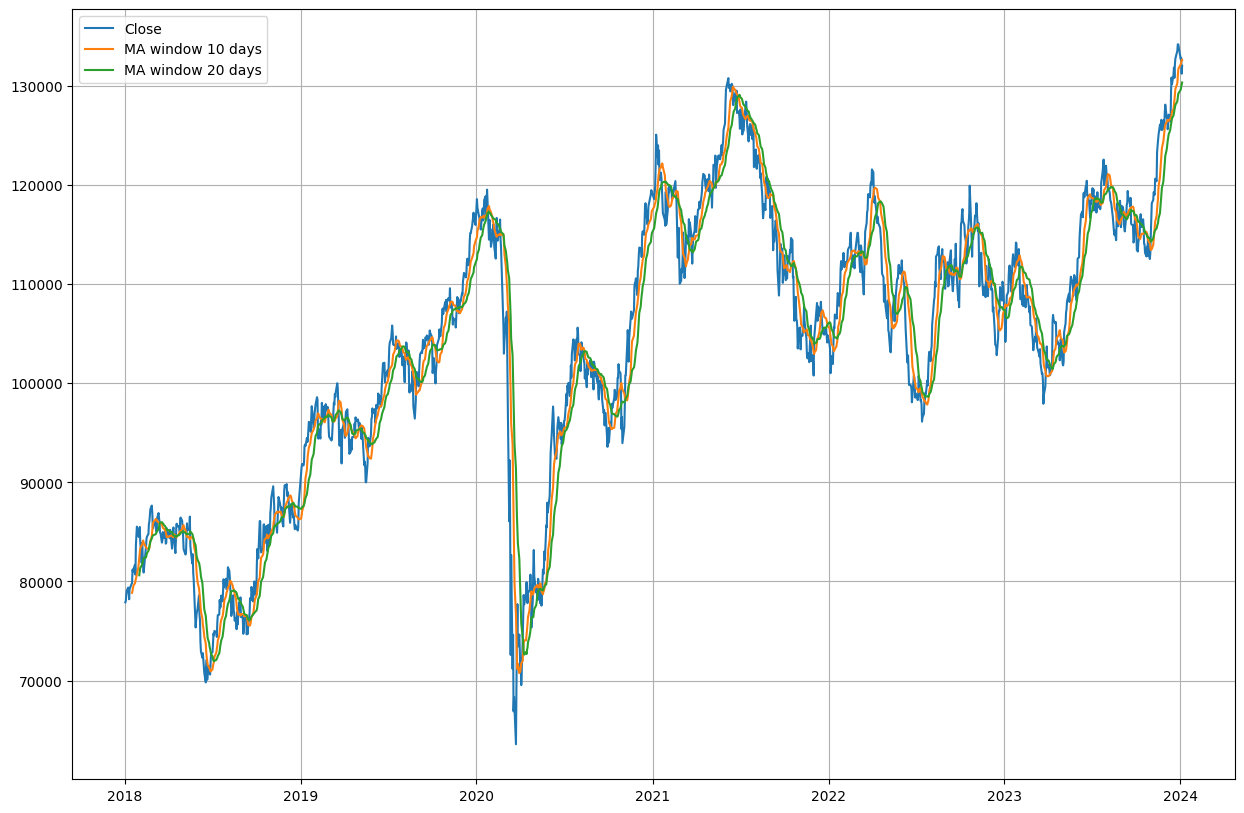

In [91]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: últimos 300 dias

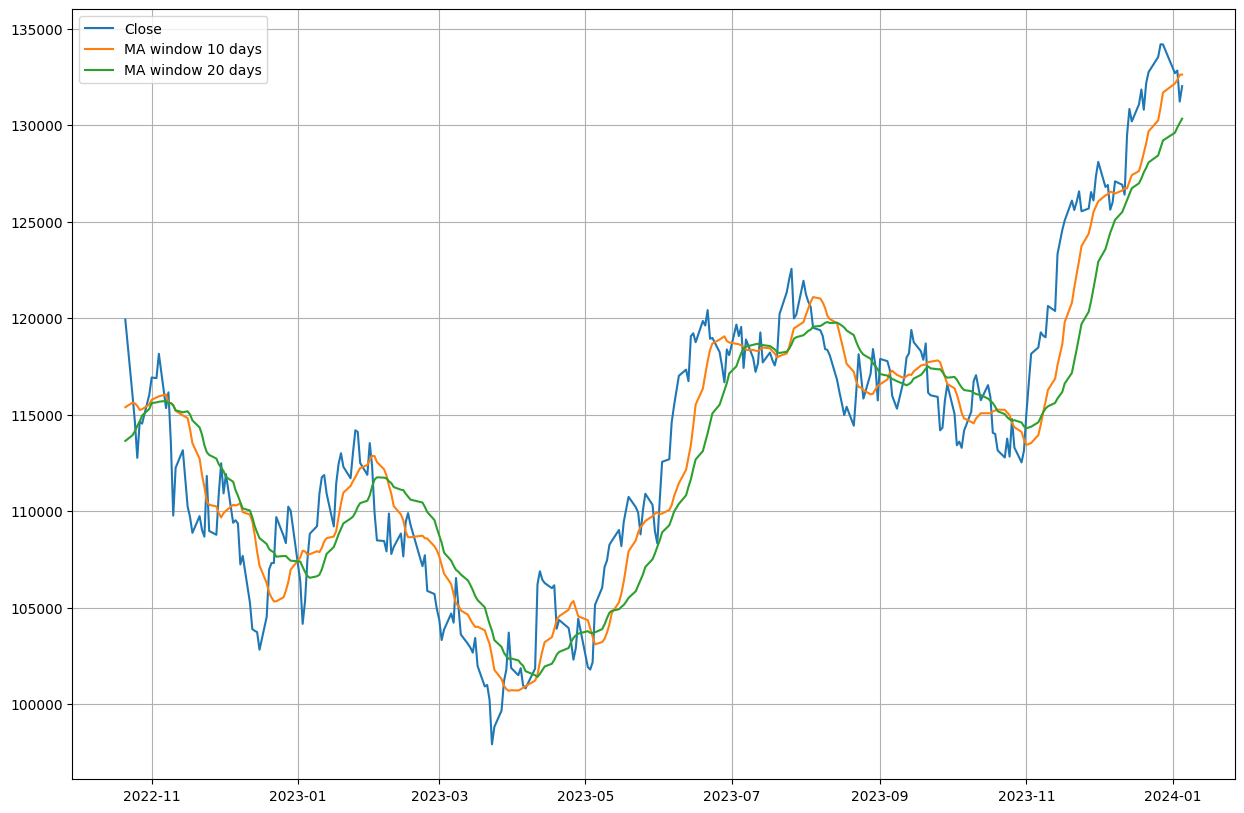

In [92]:
limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na média móvel aritmética

In [93]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [94]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [95]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


Esse trecho de código parece implementar um cálculo de média móvel ponderada em uma série temporal usando janelas deslizantes. Vou explicar o que cada parte do código está fazendo:

```python
window_size = 10  # Tamanho da janela para a média móvel
forward_days = 10  # Quantidade de dias para avançar na iteração
```

Estas são definições dos parâmetros para a média móvel e para o avanço na iteração sobre a série temporal.

```python
for index in range(window_size, len(df), forward_days):
```

Isso cria um loop que percorre a série temporal com uma janela deslizante. Ele começa no índice `window_size`, indo até o comprimento total da série `df`, avançando `forward_days` a cada iteração.

```python
    for i in range(0, forward_days):
```

Dentro do loop principal, há um segundo loop que itera sobre os dias adiante (`forward_days`) para calcular a média móvel ponderada.

```python
        if index + i >= len(df):
            break
```

Esse `if` verifica se o índice atual somado com `i` ultrapassa o comprimento total da série temporal `df`. Se isso ocorrer, sai do loop.

```python
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)
```

Duas janelas são criadas:
- `window_close`: Uma janela para calcular a média móvel ponderada, diminuindo o tamanho da janela à medida que o loop avança.
- `window_MA`: Uma janela para a série temporal original, aumentando seu tamanho à medida que o loop avança.

```python
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)
```

A média móvel ponderada é calculada, tomando a média entre a janela para a média móvel (`window_close`) e a janela para a série temporal original (`window_MA`).

```python
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean
```

Finalmente, a média móvel ponderada calculada é inserida no DataFrame `df` na coluna denominada `'MA_window_10_forward_10'` para o índice correspondente à posição atual do loop.

Essencialmente, este código itera sobre a série temporal, calculando médias móveis ponderadas para diferentes janelas deslizantes ao longo da série e atualizando o DataFrame com os resultados.

Plotando os dados:

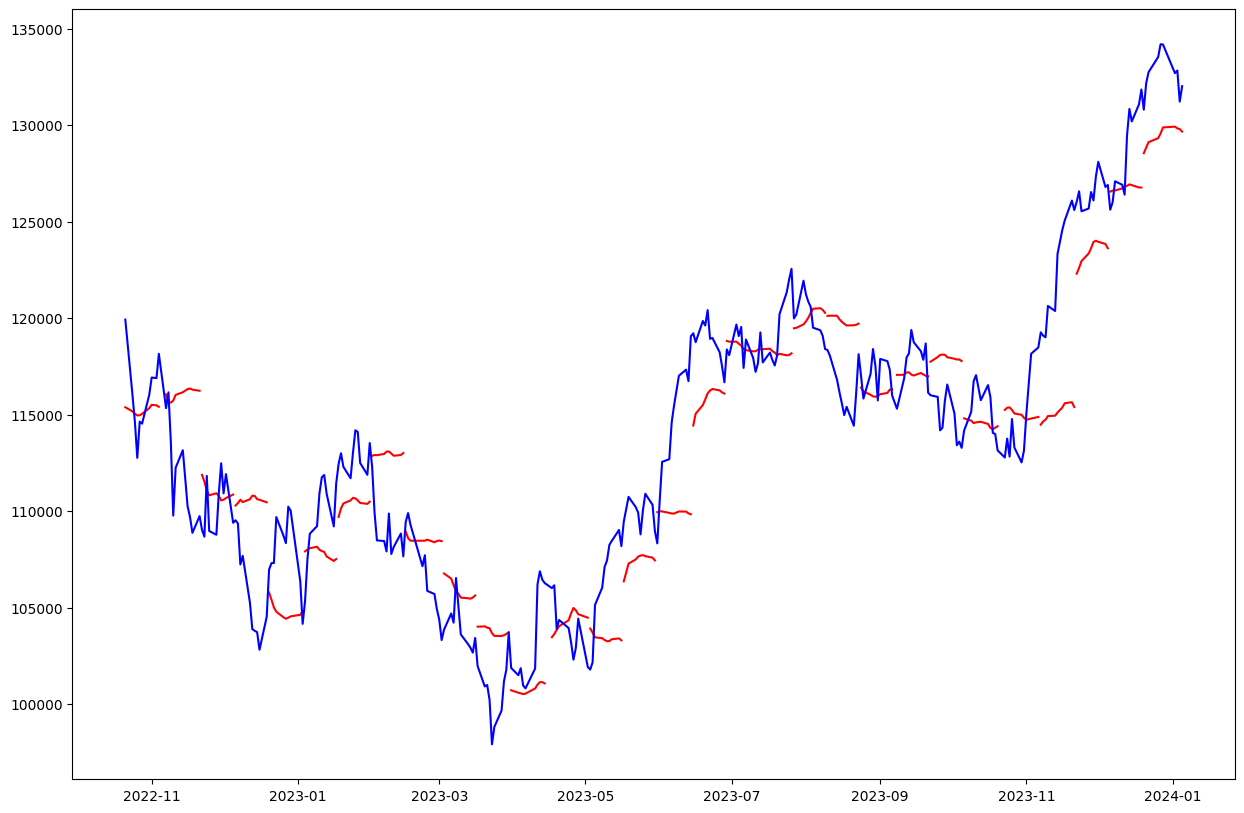

In [96]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Note que cada reta vermelha no gráfico representa uma previsão de 10 dias, baseado nos 10 dias anteriores. Por isso elas são descontínuas.

Este tipo de abordagem é muito simplista. Isto porque o verdadeiro objetivo é prever N dias a frente para ver qual será o comportamento da ação. E ambos algoritmos falham nessa função. Vamos testar mais um clássico? Vamos analisar como o ARIMA funciona.

## Testando o modelo ARIMA 💹

ARIMA significa **Média Móvel Integrada Auto-Regressiva**.

Um modelo ARIMA é uma classe de modelos estatísticos para analisar e prever dados de séries temporais. Enquanto os modelos de suavização exponencial são baseados na descrição da tendência e sazonalidade dos dados, os modelos ARIMA visam descrever as **autocorrelações nos dados**.

---
O algoritmo ARIMA utiliza **autoregressão** + **médias móveis** + **diferenciação**.

---

 Os **termos autoregressivos** permitem que o **modelo capture a influência dos valores passados na série temporal**. Os termos de **média móvel permitem que o modelo capture os erros de previsão passados**. A **diferenciação permite que o modelo capture tendências** na série temporal.


❗ Antes de falarmos sobre o modelo ARIMA, vamos falar sobre o conceito de **estacionariedade** e a técnica de **diferenciação** de séries temporais.

**O que é estacionaridade? 🤔**

Para trabalhar com séries temporais utilizando o modelo ARIMA, precisamos que ela **seja estacionária**. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em ***certos períodos possui a mesma média***.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

### Hiperparâmetros do algortimo:

- P - Número de **lags** que devem ser incluídos no modelo *(lags são valores auto correlacionados que devem ser levados em consideração, ou seja, os valores históricos que serão utilizados para prever o futuro.*)
- D - Número de vezes que as **observações serão diferenciadas**. (*tornar a série estacionária*)
- Q - Ordem de média móvel, **tamanho de uma janela (lag) de média móvel**.(*para calcular o erro e encontrar a melhor previsão (tamanho da janela da media móvel) para calcular os residuos e fazer o forecast*).

### Passos para aplicar o ARIMA:

1. Visualize os dados da série temporal 📈
2. Identifique se a data é estacionária ✅
3. Plote os gráficos de correlação e autocorrelação 🤔
4. Construir o modelo ARIMA com base nos dados 🔨

## Analisando a correlação dos dados:

Ao trabalhar com modelos ARIMA, uma etapa importante é **entender a autocorrelação presente nos dados**. A autocorrelação refere-se à correlação de uma série temporal com uma versão atrasada de si mesma. Para entender e visualizar essa autocorrelação, utilizamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

#### Autocorrelação e Autocorrelação parcial:

- ACF (autocorrelação) temos a correlação direta e indireta.
- PACF (autocorrelação parcial): apenas a correlação direta.

A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados. Os lags são os intervalos de atraso entre as observações. Cada ponto no gráfico indica a correlação entre a série temporal e ela mesma em diferentes pontos no passado.

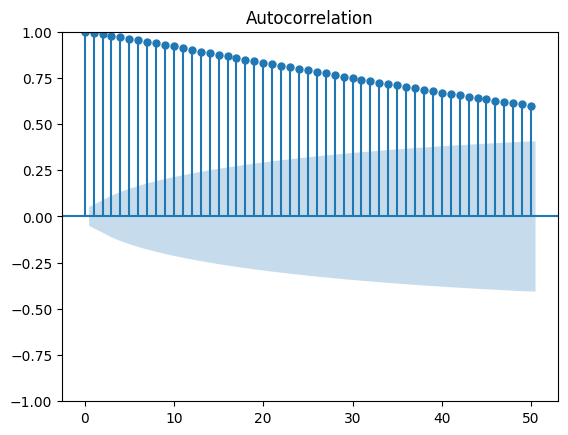

In [97]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

O intervalo de confiança por padrão é 95%, mostrado como essa marca azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.

A interpretação do ACF geralmente envolve identificar padrões significativos de autocorrelação nos lags. Se a autocorrelação em um determinado lag for significativa (por exemplo, ultrapassando linhas pontilhadas que indicam intervalos de confiança), isso sugere uma possível sazonalidade ou padrão repetitivo nos dados.

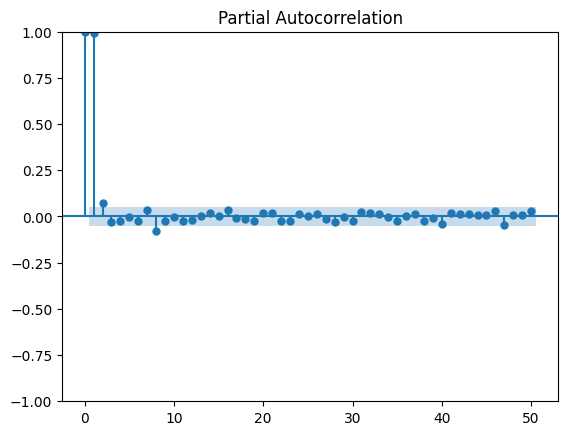

In [98]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

Fazendo a análise de correlação parcial direta, os lags não contribuem significativamente para a estrutura da autocorrelação parcial após considerar os efeitos dos lags intermediários (veja os lags na área em azul).

A interpretação do PACF geralmente está relacionada à identificação do atraso específico que contribui para a autocorrelação em um determinado ponto. Ou seja, **ajuda a identificar a ordem de defasagem apropriada para um modelo AR (autoregressivo)**.


## Analisando a média móvel com o desvio padrão



In [99]:
rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

                    Close
Date                     
2018-01-02            NaN
2018-01-03            NaN
2018-01-04            NaN
2018-01-05            NaN
2018-01-08            NaN
...                   ...
2023-12-28  131457.750000
2024-01-02  131982.250000
2024-01-03  132263.000000
2024-01-04  132295.000000
2024-01-05  132447.166667

[1490 rows x 1 columns]                   Close
Date                   
2018-01-02          NaN
2018-01-03          NaN
2018-01-04          NaN
2018-01-05          NaN
2018-01-08          NaN
...                 ...
2023-12-28  2208.367193
2024-01-02  1547.131723
2024-01-03  1340.721176
2024-01-04  1307.902763
2024-01-05  1136.630973

[1490 rows x 1 columns]


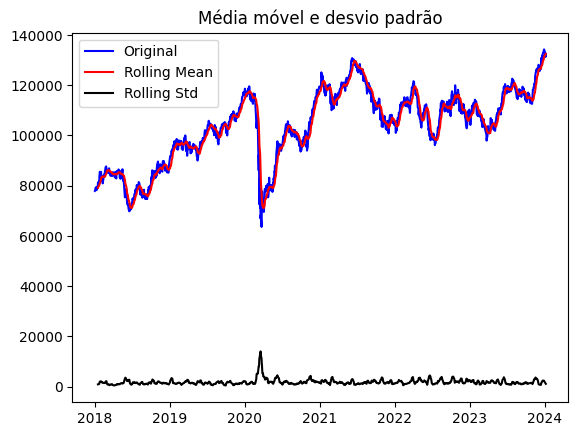

In [100]:
#Plotando a média móvel
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

No gráfico acima, vemos que a própria média móvel tem um componente de tendência, embora o desvio padrão contínuo seja bastante constante com o tempo. Para que nossa série temporal seja estacionária, precisamos garantir que ambas as estatísticas tenham uma tendência.

O desvio padrão é uma medida de dispersão que quantifica o quanto os valores em um conjunto de dados tendem a se afastar da média. Neste caso, podemos observar que os dados variam muito!

Mas, como podemos comprovar realmente que esta série temporal não é estacionária?


# Verificar estacionariedade da série temporal 📈

# Teste de Dickey-Fuller ✍


Para aumentar ainda mais nossa hipótese de que a série temporal não é estacionária, vamos realizar o teste ADCF:

O teste de ***Dickey-Fuller Aumentado (ADF)*** permite saber sem **há presença significativa de tendência nas séries temporais** das variáveis por meio de um teste de hipótese.



**Estatística ADF:**

- H0 (Hipótese Nula): A série temporal não é estacionária.

- H1 (Hipótese Alternativa): A série temporal é estacionária.


**Interpretação:** Se a estatística ADF for menor que os valores críticos, podemos rejeitar a hipótese nula e considerar a série temporal estacionária. Quanto mais negativa a estatística, mais forte é a evidência contra a hipótese nula.

**Valor p (p-value):**

**Interpretação:** Um valor p menor que um determinado nível de significância (**por exemplo, 0.05**) fornece evidência contra a hipótese nula, sugerindo que a série temporal é estacionária.

**Estacionariedade**
Para trabalhar com séries temporais em alguns modelos, precisamos que ela seja estacionária. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em certos períodos possui a mesma média.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

In [101]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.184098423331641
p-value: 0.21206734800211458
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.184098423331641
Valor-p: 0.21206734800211458
Valores Críticos:
   1%: -3.434773140073479
   5%: -2.8634935294626773
   10%: -2.5678100382791524


Para que uma série temporal seja estacionária, seu teste ADCF:

- valor p alto (de acordo com a hipótese nula) (valor p no máximo pode ser 1)
- Os valores críticos em intervalos de confiança de 1%,5%,10% devem ser o mais próximo possível das Estatísticas de Teste.

Portanto, podemos dizer com segurança que nossa Série Temporal no momento **não** é estacionária.


# Transformando a série e estacionária

### 1º teste 🔍: subtrair os dados transformados pelo log pela média móvel.


**Objetivo:** Estabilizar a variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.



---



Vamos utilizar o **logarítmo** para realizar a transformação dos dados. Nosso objetivo é **remover o componente de tendência**. Portanto, curvas mais planas (ou seja: paralelas ao eixo x) para séries temporais e médias contínuas após obter o log diriam que nossa transformação de dados fez um bom trabalho.

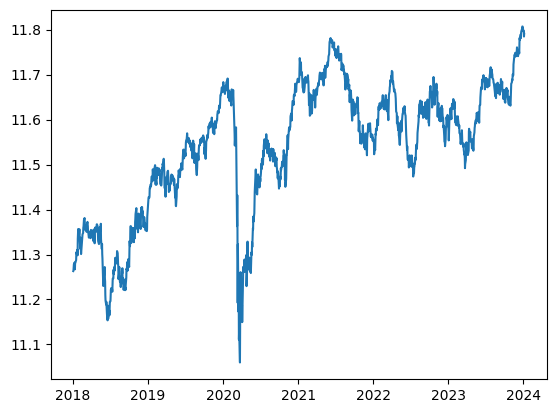

In [102]:
#Estimating trend
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

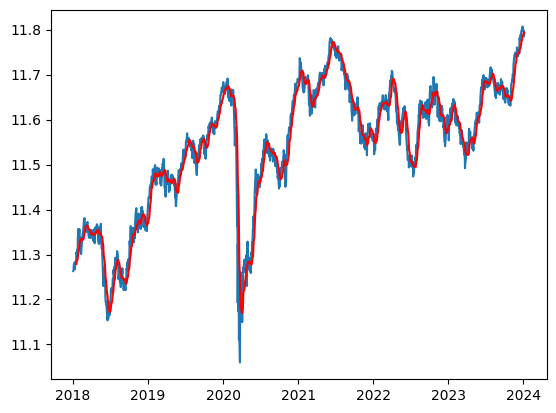

In [103]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

Vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos. (Aqui buscamos isolar os padrões sazonais ou os componentes residuais.)



In [104]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Close
Date,
2018-01-17,0.025775
2018-01-18,0.019765
2018-01-19,0.019557
2018-01-22,0.021996
2018-01-23,0.008037
2018-01-24,0.040174
2018-01-26,0.055290
2018-01-29,0.038852
2018-01-30,0.031092


In [105]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


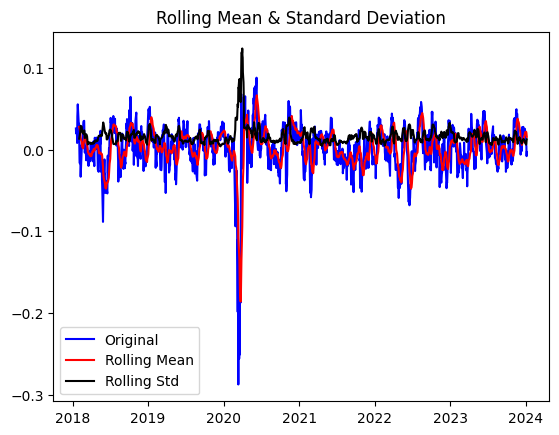

Results of Dickey Fuller Test:
Test Statistic                -9.539656e+00
p-value                        2.748394e-16
#Lags Used                     7.000000e+00
Number of Observations Used    1.471000e+03
Critical Value (1%)           -3.434803e+00
Critical Value (5%)           -2.863507e+00
Critical Value (10%)          -2.567817e+00
dtype: float64


In [106]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Para interpretar os resultados:

- **Test Statistic (Estatística do Teste):** É o valor da estatística do teste Dickey-Fuller. Quanto mais negativo for (ou seja, menor que os valores críticos), mais forte é a evidência contra a hipótese nula (a série não é estacionária). Neste caso, o valor é bastante negativo, indicando forte evidência contra a hipótese nula.

- **p-value (Valor p):** Indica a probabilidade de se observar a estatística do teste (ou uma mais extrema) sob a hipótese nula. Um valor de p pequeno (geralmente abaixo de 0,05) sugere rejeição da hipótese nula, indicando que a série é estacionária. No seu caso, o valor p é muito pequeno (1.92e-07), o que fortalece a evidência contra a hipótese nula.

- **#Lags Used (Número de Defasagens Utilizadas):** Representa o número de defasagens incluídas no modelo. Neste caso, foram utilizadas 8 defasagens.

- **Number of Observations Used (Número de Observações Utilizadas):** É a quantidade de observações utilizadas no teste. Aqui, foram utilizadas 1481 observações.

- **Critical Values (Valores Críticos):** Esses valores representam os limites em que você pode comparar o valor do teste estatístico para determinar se a série é estacionária. Se o valor do teste estiver abaixo desses limites, você pode rejeitar a hipótese nula. Os valores críticos fornecidos são para diferentes níveis de significância (1%, 5%, 10%).

Com base nos resultados apresentados, a estatística do teste é menor do que os valores críticos, e o valor p é muito pequeno, indicando forte evidência para rejeitar a hipótese nula. Portanto, é provável que a série temporal seja estacionária.

### 2º teste : Decaimento exponencial.



---



**Objetivo:** Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.


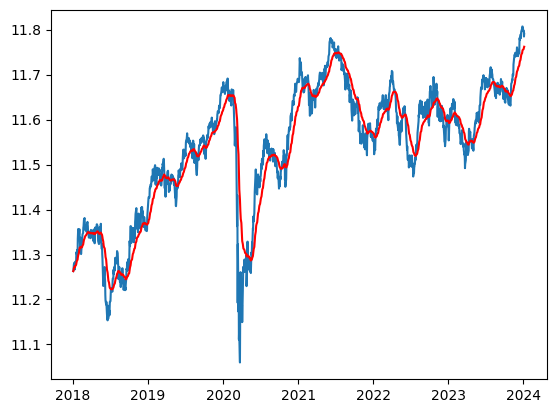

In [107]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

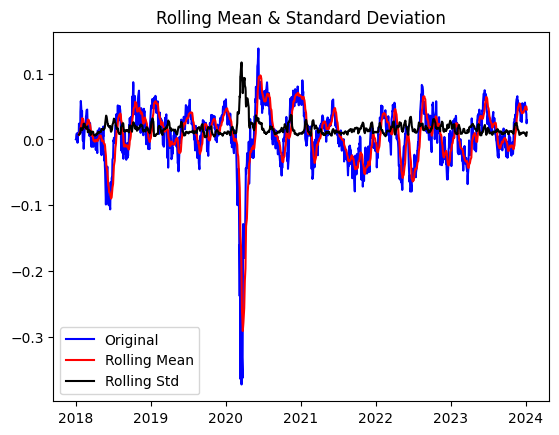

Results of Dickey Fuller Test:
Test Statistic                -5.972329e+00
p-value                        1.923122e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.481000e+03
Critical Value (1%)           -3.434773e+00
Critical Value (5%)           -2.863494e+00
Critical Value (10%)          -2.567810e+00
dtype: float64


In [108]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3º teste : Diferenciação



---



**Objetivo:** Remover a tendência e tornar a série mais estacionária.

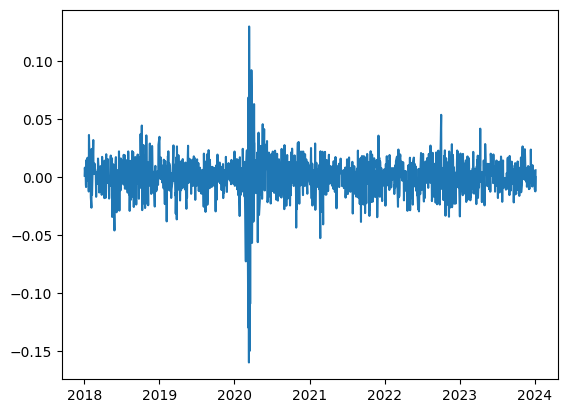

In [109]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

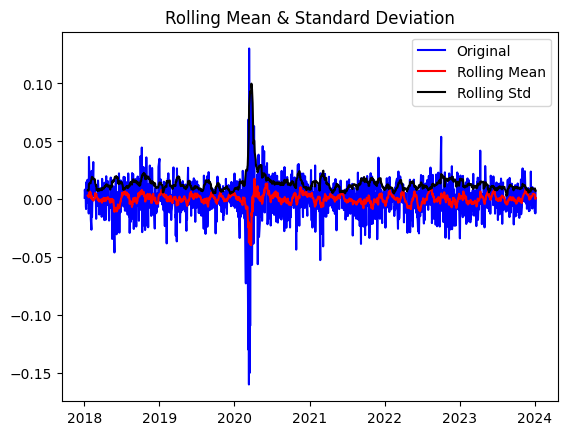

Results of Dickey Fuller Test:
Test Statistic                -1.196599e+01
p-value                        3.999462e-22
#Lags Used                     7.000000e+00
Number of Observations Used    1.481000e+03
Critical Value (1%)           -3.434773e+00
Critical Value (5%)           -2.863494e+00
Critical Value (10%)          -2.567810e+00
dtype: float64


In [110]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Teste de correlação parcial

Como definimos numa primeira tentativa o parâmetro **P (lags: valores auto correlacionados)** e o parâmetro **Q (tamanho de uma janela)** do ARIMA?

Vamos fazer isso com os **gráfico de ACF** (para ‘q’) e o **gráfico de PACF** (para ‘p’). Vamos selecionar como teste a base de dados da **diferenciação**.

Vamos encontrar em **qual ponto cada gráfico passa em zero e este ponto será o valor de P e Q inicial** (talvez em alguns casos pequenas alterações nos parâmetros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags é o número de amostras):

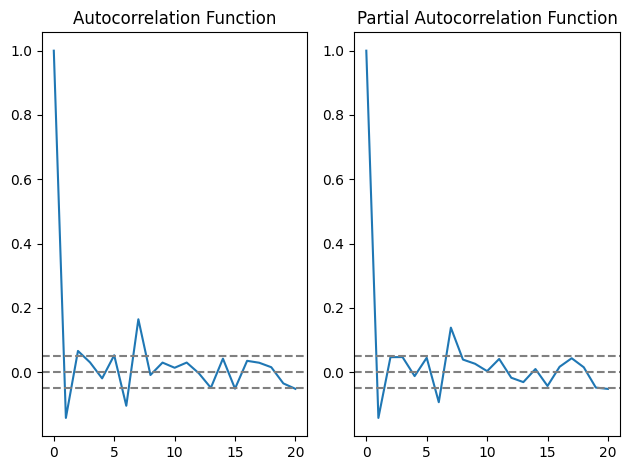

In [111]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

A partir do gráfico ACF, vemos que a curva toca a linha y=0,0 em x=1 (Q = 2);

Do gráfico PACF, vemos que a curva toca a linha y=0,0 em x=1 (P = 2).

ARIMA é AR + I + MA. Antes, vemos um modelo ARIMA, vamos verificar os resultados do modelo AR & MA individual. Observe que esses modelos fornecerão um valor de RSS (Soma dos Quadrados dos Resíduos). Valores RSS mais baixos indicam um modelo melhor.

Com o RSS você está avaliando o quão longe seus pontos estão dos valores verdadeiros. Uma maneira de validar o seu modelo ARIMA é verificar se seu RSS diminui à medida que você faz alterações em seu modelo.

In [112]:
#! pip install --upgrade statsmodels

Plotting AR model


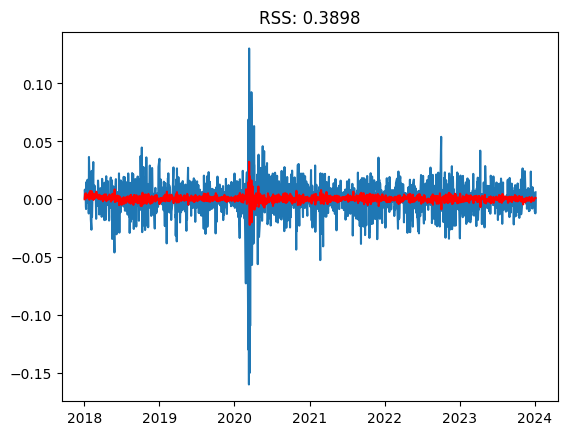

In [113]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

**Validando o modelo com MAPE  (Mean Absolute Percentage Error)**

 Métrica para valiar a precisão de previsões em séries temporais (perspectiva percentual dos erros). Quanto menor, melhor!
😊

In [114]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1174.34%


Um MAPE tão alto geralmente indica que as previsões do modelo estão muito distantes dos valores reais. 😞

# Testando o modelo com prophet 🔮

O prophet é uma ferramenta de previsão para séries temporais desenvolvida pelo Facebook. O Prophet é especialmente projetado para lidar com **séries temporais que possuem padrões sazonais fortes e vários pontos de mudança**.

O Prophet é um vidente, capaz de entender e prever tendências, sazonalidades e feriados.🔮 Mágico né?

O Prophet se destaca em sua capacidade de lidar com dados faltantes, tendências que mudam ao longo do tempo e até mesmo feriados! Ele foi projetado para ser flexível e intuitivo, tornando a previsão de séries temporais uma tarefa mais simples, mesmo para aqueles que não são especialistas em estatística.


In [115]:
# Especifique o símbolo da Disney (DIS) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-08'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()



[*********************100%%**********************]  1 of 1 completed


,Date,Close,ds,y
0,2018-01-02,77891.0,2018-01-02,77891.0
1,2018-01-03,77995.0,2018-01-03,77995.0
2,2018-01-04,78647.0,2018-01-04,78647.0
3,2018-01-05,79071.0,2018-01-05,79071.0
4,2018-01-08,79379.0,2018-01-08,79379.0


## Seprando os dados em treino e teste

In [116]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1192, 4)
testing data size : (298, 4)


In [117]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

22:47:14 - cmdstanpy - INFO - Chain [1] start processing


22:47:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,77903.240238,76544.223629,91191.987247,77903.240238,77903.240238,5494.907193,5494.907193,5494.907193,2218.355646,...,306.498949,306.498949,306.498949,2970.052598,2970.052598,2970.052598,0.0,0.0,0.0,83398.147431
1,2018-01-03,77906.280552,76335.906546,91313.953112,77906.280552,77906.280552,5309.431902,5309.431902,5309.431902,2218.355646,...,33.086897,33.086897,33.086897,3057.989358,3057.989358,3057.989358,0.0,0.0,0.0,83215.712454
2,2018-01-04,77909.320865,76034.308143,91021.111847,77909.320865,77909.320865,5562.175562,5562.175562,5562.175562,2218.355646,...,194.754867,194.754867,194.754867,3149.065049,3149.065049,3149.065049,0.0,0.0,0.0,83471.496427
3,2018-01-05,77912.361179,76302.120419,91406.236307,77912.361179,77912.361179,5825.156412,5825.156412,5825.156412,2218.355646,...,364.149116,364.149116,364.149116,3242.651649,3242.651649,3242.651649,0.0,0.0,0.0,83737.517591
4,2018-01-08,77921.482120,76007.348618,90719.257307,77921.482120,77921.482120,5406.396695,5406.396695,5406.396695,2218.355646,...,-343.902231,-343.902231,-343.902231,3531.943280,3531.943280,3531.943280,0.0,0.0,0.0,83327.878815


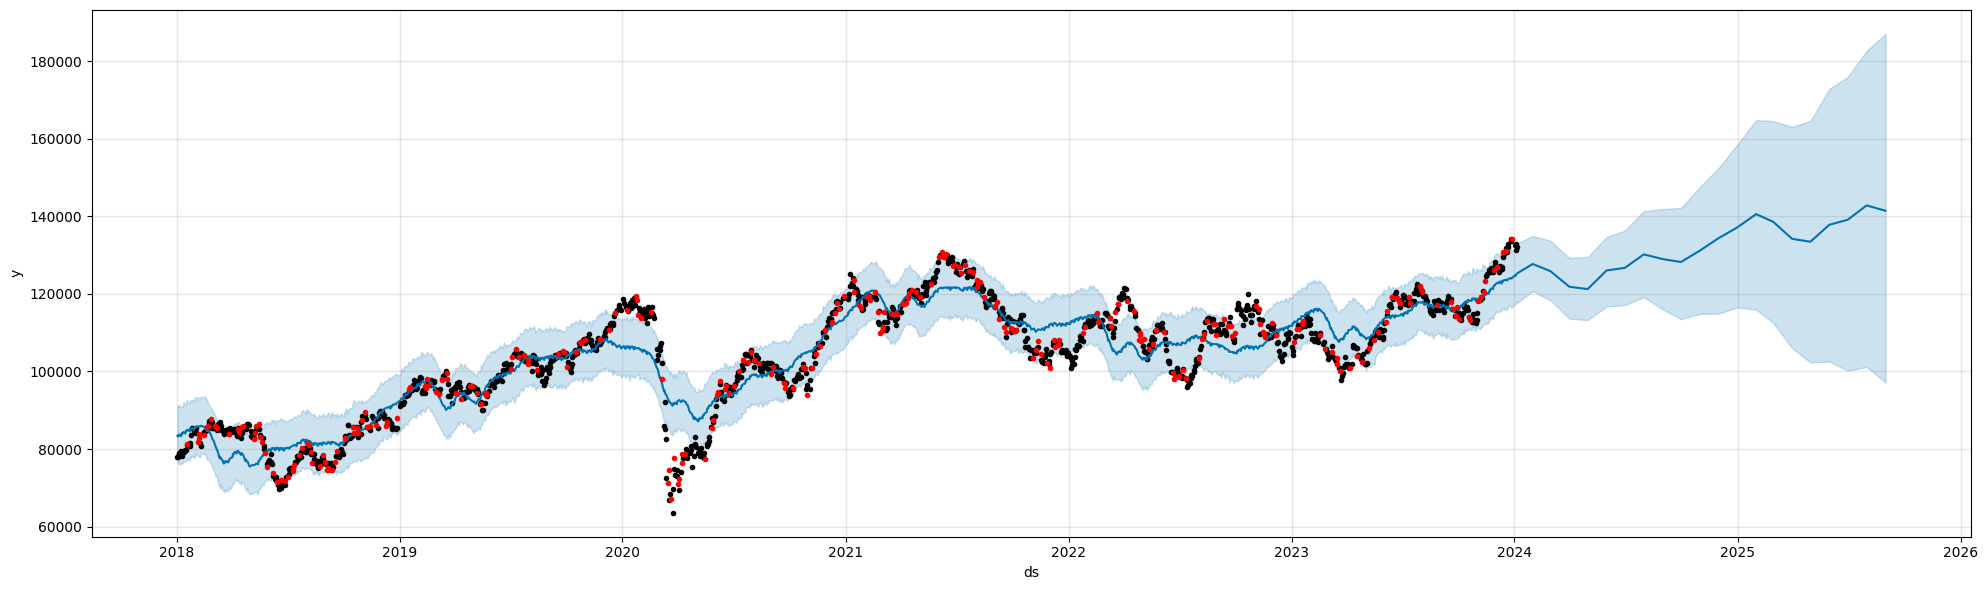

In [118]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

Uma das características mais úteis do Prophet é sua capacidade de decompor automaticamente uma série temporal em seus componentes. Isso inclui a tendência geral, sazonalidade anual e efeitos de feriados (se fornecidos)

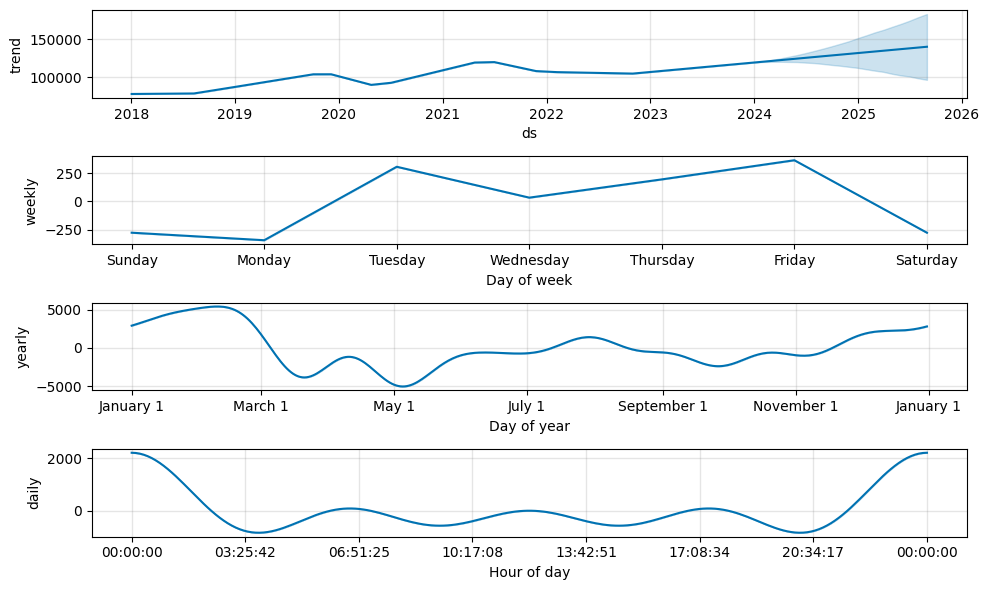

In [119]:
modelo.plot_components(previsao, figsize=(10,6));

In [120]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.49%


In [121]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,77903.240238,75604.559683,91090.967131,77903.240238,77903.240238,5494.907193,5494.907193,5494.907193,2218.355646,...,306.498949,306.498949,306.498949,2970.052598,2970.052598,2970.052598,0.0,0.0,0.0,83398.147431
1,2018-01-03,77906.280552,76001.485124,90529.693722,77906.280552,77906.280552,5309.431902,5309.431902,5309.431902,2218.355646,...,33.086897,33.086897,33.086897,3057.989358,3057.989358,3057.989358,0.0,0.0,0.0,83215.712454
2,2018-01-04,77909.320865,75835.545839,91091.109988,77909.320865,77909.320865,5562.175562,5562.175562,5562.175562,2218.355646,...,194.754867,194.754867,194.754867,3149.065049,3149.065049,3149.065049,0.0,0.0,0.0,83471.496427
3,2018-01-05,77912.361179,76998.088674,91288.644889,77912.361179,77912.361179,5825.156412,5825.156412,5825.156412,2218.355646,...,364.149116,364.149116,364.149116,3242.651649,3242.651649,3242.651649,0.0,0.0,0.0,83737.517591
4,2018-01-08,77921.482120,76024.982783,90155.266742,77921.482120,77921.482120,5406.396695,5406.396695,5406.396695,2218.355646,...,-343.902231,-343.902231,-343.902231,3531.943280,3531.943280,3531.943280,0.0,0.0,0.0,83327.878815


In [122]:
previsao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          1212 non-null   datetime64[ns]
 1   trend                       1212 non-null   float64       
 2   yhat_lower                  1212 non-null   float64       
 3   yhat_upper                  1212 non-null   float64       
 4   trend_lower                 1212 non-null   float64       
 5   trend_upper                 1212 non-null   float64       
 6   additive_terms              1212 non-null   float64       
 7   additive_terms_lower        1212 non-null   float64       
 8   additive_terms_upper        1212 non-null   float64       
 9   daily                       1212 non-null   float64       
 10  daily_lower                 1212 non-null   float64       
 11  daily_upper                 1212 non-null   float64     

In [123]:
previsao

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,77903.240238,75604.559683,91090.967131,77903.240238,77903.240238,5494.907193,5494.907193,5494.907193,2218.355646,...,306.498949,306.498949,306.498949,2970.052598,2970.052598,2970.052598,0.0,0.0,0.0,83398.147431
1,2018-01-03,77906.280552,76001.485124,90529.693722,77906.280552,77906.280552,5309.431902,5309.431902,5309.431902,2218.355646,...,33.086897,33.086897,33.086897,3057.989358,3057.989358,3057.989358,0.0,0.0,0.0,83215.712454
2,2018-01-04,77909.320865,75835.545839,91091.109988,77909.320865,77909.320865,5562.175562,5562.175562,5562.175562,2218.355646,...,194.754867,194.754867,194.754867,3149.065049,3149.065049,3149.065049,0.0,0.0,0.0,83471.496427
3,2018-01-05,77912.361179,76998.088674,91288.644889,77912.361179,77912.361179,5825.156412,5825.156412,5825.156412,2218.355646,...,364.149116,364.149116,364.149116,3242.651649,3242.651649,3242.651649,0.0,0.0,0.0,83737.517591
4,2018-01-08,77921.482120,76024.982783,90155.266742,77921.482120,77921.482120,5406.396695,5406.396695,5406.396695,2218.355646,...,-343.902231,-343.902231,-343.902231,3531.943280,3531.943280,3531.943280,0.0,0.0,0.0,83327.878815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,2025-04-30,135863.057585,101840.999567,164438.771129,103040.515594,166403.313473,-2415.915403,-2415.915403,-2415.915403,2218.355646,...,33.086897,33.086897,33.086897,-4667.357946,-4667.357946,-4667.357946,0.0,0.0,0.0,133447.142183
1208,2025-05-31,136921.019409,101638.932930,171865.294812,100936.016139,170473.191801,905.292678,905.292678,905.292678,2218.355646,...,-277.294152,-277.294152,-277.294152,-1035.768816,-1035.768816,-1035.768816,0.0,0.0,0.0,137826.312088
1209,2025-06-30,137944.853433,99414.465780,175651.498054,99092.405716,175104.320898,1154.669851,1154.669851,1154.669851,2218.355646,...,-343.902231,-343.902231,-343.902231,-719.783564,-719.783564,-719.783564,0.0,0.0,0.0,139099.523284
1210,2025-07-31,139002.815257,101530.024876,182592.593935,97138.310235,179152.543702,3802.954860,3802.954860,3802.954860,2218.355646,...,194.754867,194.754867,194.754867,1389.844348,1389.844348,1389.844348,0.0,0.0,0.0,142805.770117


In [124]:
# from prophet.diagnostics import performance_metrics

# df_p = performance_metrics(previsao)
# df_p.head()

## Cross validation


In [125]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/7 [00:00<?, ?it/s]22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing


 14%|█▍        | 1/7 [00:00<00:02,  2.69it/s]22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:01,  3.29it/s]22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:00<00:01,  3.18it/s]22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:01<00:01,  2.88it/s]22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:01<00:00,  2.92it/s]22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:02<00:00,  2.72it/s]22:47:19 - cmdstanpy - INFO - Chain [1] start processing
22:47:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


In [126]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-01-22,119513.923502,117366.096111,121677.090631,118391.0,2020-01-21
1,2020-01-28,120567.184108,118546.406250,122790.188949,116479.0,2020-01-21
2,2020-01-29,120607.716874,118469.919639,122736.828111,115385.0,2020-01-21
3,2020-01-30,120915.259975,118786.873704,123057.490223,115528.0,2020-01-21
4,2020-02-03,121230.535397,118948.374593,123422.790197,114629.0,2020-01-21


In [127]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1.174299e+08,10836.509537,8847.899035,0.081333,0.066891,0.083325,0.344203
1,37 days,1.237638e+08,11124.916603,9078.466668,0.083517,0.066891,0.085522,0.336957
2,38 days,1.292457e+08,11368.627934,9275.958712,0.085365,0.068753,0.087325,0.326087
3,39 days,1.334258e+08,11551.008103,9444.797853,0.086940,0.069783,0.089110,0.313043
4,40 days,1.405239e+08,11854.275813,9729.757634,0.089482,0.074358,0.091861,0.297101
...,...,...,...,...,...,...,...,...
325,361 days,1.832478e+09,42807.453060,36369.501489,0.321144,0.256760,0.326099,0.463768
326,362 days,1.857049e+09,43093.494715,36693.329344,0.324864,0.256760,0.328063,0.452174
327,363 days,1.841835e+09,42916.601170,36558.110825,0.323923,0.258424,0.325529,0.449275
328,364 days,1.842431e+09,42923.550747,36565.383853,0.325201,0.258424,0.323384,0.449275


https://facebook.github.io/prophet/docs/diagnostics.html

### Aplicando o algoritmo LSTM para prever 🤖

Vamos agora utilizar uma Rede LSTM (Long Short-Term Memory) para prever o comportamento da empresa.

LSTM é um tipo especial de **rede neural recorrente**, pois são capazes de aprender conexões de longo prazo. Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo em séries temporais, textos longos, gravações de áudios e muito mais. O principal trabalho dessa rede neural se torna entender como uma memória deve influenciar a outra, ou seja, como a rede decide quais partes da memória de curto prazo devem ser lembradas e como a memória de longo prazo deve afetar o entendimento atual do texto.



In [128]:
df = df_ibovespa
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

,Date,Close
0,2018-01-02,77891.0
1,2018-01-03,77995.0
2,2018-01-04,78647.0
3,2018-01-05,79071.0
4,2018-01-08,79379.0


In [129]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

### Normalizando os dados

In [130]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

### Separação da base de treino e teste:

In [131]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1192
298


In [132]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [133]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1804 - mean_squared_error: 0.1797
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mean_squared_error: 0.0044
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0019
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0014
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - me

In [134]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Erro Quadrático Médio 0.0012270916486158967


In [135]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 2.0576


In [136]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.035029867950306305


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.024 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão. Esse modelo ficou top né?

In [137]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

 50/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Será que podemos melhorar esses resultados?

# Validando com suavização da série temporal

In [138]:
df = df_ibovespa
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Close
0,2018-01-02,77891.0
1,2018-01-03,77995.0
2,2018-01-04,78647.0
3,2018-01-05,79071.0
4,2018-01-08,79379.0


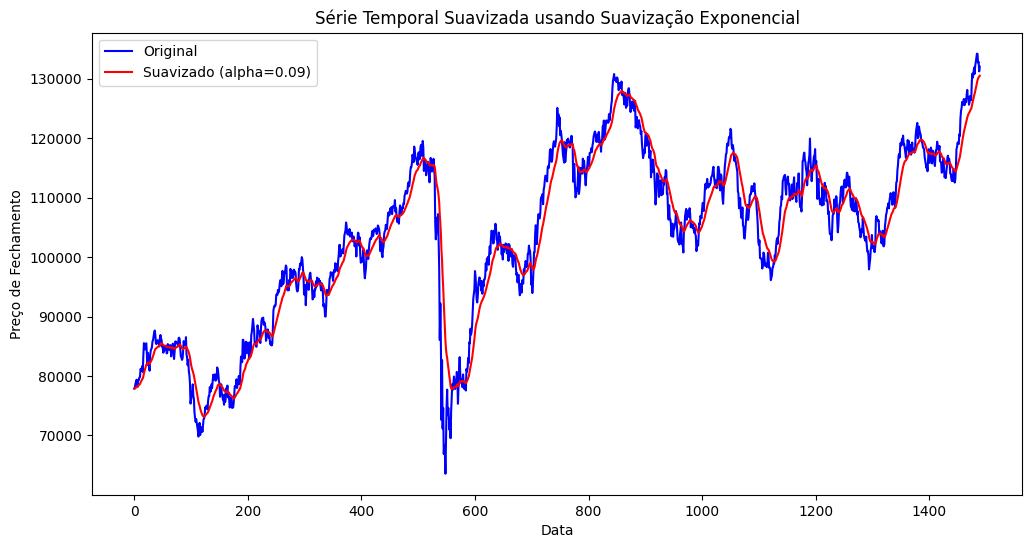

In [139]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [140]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.407079364755799
p-value: 0.13974827175093718
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.407079364755799
Valor-p: 0.13974827175093718
Valores Críticos:
   1%: -3.434773140073479
   5%: -2.8634935294626773
   10%: -2.5678100382791524


In [141]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2018-01-02,77891.000000
1,2018-01-03,77900.360000
2,2018-01-04,77967.557600
3,2018-01-05,78066.867416
4,2018-01-08,78184.959349


In [142]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [143]:
close_data

array([[0.08222908],
       [0.0823924 ],
       [0.08356487],
       ...,
       [0.99582635],
       [0.99735624],
       [1.        ]])

In [144]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1192
298


In [145]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [146]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2146 - mean_squared_error: 0.2150
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0027
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3230e-04 - mean_squared_error: 5.3666e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1277e-04 - mean_squared_error: 6.1993e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7497e-04 - mean_squared_error: 5.7293e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7237e-04 - mean_squared_error: 4.7347e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0969e-04 - mean_squared_error: 4.1409e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9546e-04 - mean_squared_error: 5.9075e-04
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7788e-04 - mean_squared_error: 4.7769e-04
Epoch

In [147]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")


293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 0.75%


In [148]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0316e-04 - mean_squared_error: 1.0316e-04
Erro Quadrático Médio: 7.831277616787702e-05


In [149]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.008849450613901239


Plotando os resultados! 📈

In [150]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

 40/293 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Realizando o Forecasting  🔮

Agora chegou o momento de prever o futuro!

Vamos criar uma função para prever o futuro, vamos passar como parametro um  número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [151]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [152]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Organizando os dados em um dataframe

In [153]:
df = pd.DataFrame(df)
df_past = df[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Date,Actual,Forecast
0,2018-01-02,77891.0000,NaN
1,2018-01-03,77900.3600,NaN
2,2018-01-04,77967.5576,NaN


In [154]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [155]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2024-01-05,NaN,130490.955882
1,2024-01-06,NaN,131324.123360
2,2024-01-07,NaN,131885.034114
3,2024-01-08,NaN,132484.881630
4,2024-01-09,NaN,133048.805388


In [156]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')
results.head()

,Actual,Forecast
Date,,
2018-01-02,77891.000000,NaN
2018-01-03,77900.360000,NaN
2018-01-04,77967.557600,NaN
2018-01-05,78066.867416,NaN
2018-01-08,78184.959349,NaN


In [157]:
results.tail()

,Actual,Forecast
Date,,
2024-01-16,NaN,137788.022316
2024-01-17,NaN,138577.306511
2024-01-18,NaN,139402.801418
2024-01-19,NaN,140268.162269
2024-01-20,NaN,141177.659194


In [158]:
results2023 =  results.loc['2023-01-01':]

In [159]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Disney'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'